Summary: Both types of differences occur in the dataset. Instances, where B predicts the positive class and A the negative class are characterized by low, but not too low x1 values and high x2 values. Instances, where A predicts the positive class and B the negative  are characterized by medium values of x1 and medium values of x2.

Explanations per cluster of instances with similar effects:

B predicts the positive class, while A predicts the negative class for instances with these characteristics:
- $-200 < x1 < -71 \land x2 > 101$ (34 instances out of 34 total) (Cluster 1)
  - if x1 was lower (≤-204), both would predict the negative class.
  - if x1 was higher (≥-8), both would predict the positive class.
  - if x2 was lower (≤97), both would predict the negative class.

A predicts the positive class, while B predicts the negative class for instances with these characteristics:
- $23 < x1 < 150 \land -87 < x2 < 77$ (64 instances out of 64 total) (Cluster 1)
  - if x1 was lower (≤-9), both would predict the negative class.
  - if x1 was higher (≥151), both would predict the positive class.
  - if x2 was lower (≤-109), both would predict the positive class.
  - if x2 was higher (≥98), both would predict the positive class.

In [9]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
from tasks.running_example import make_task
task_name = 're'

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

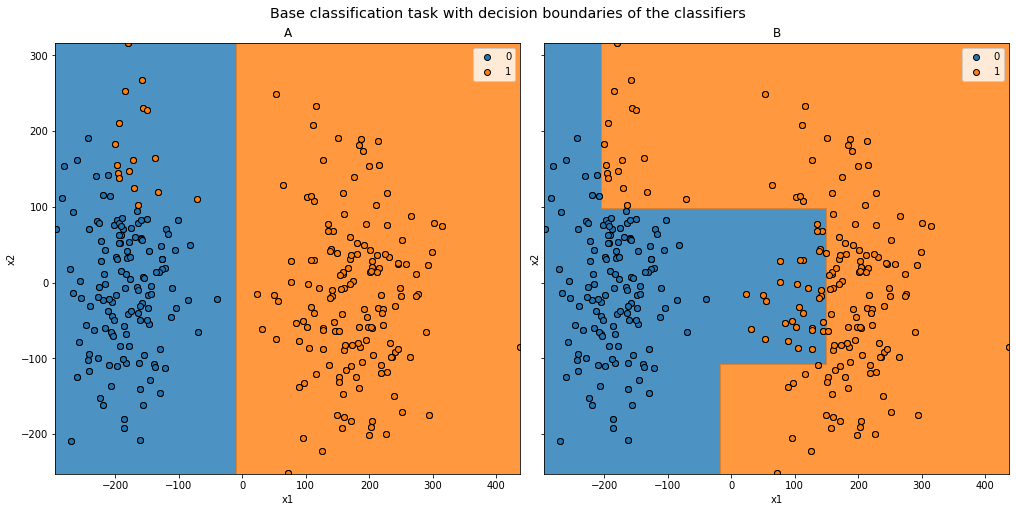

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

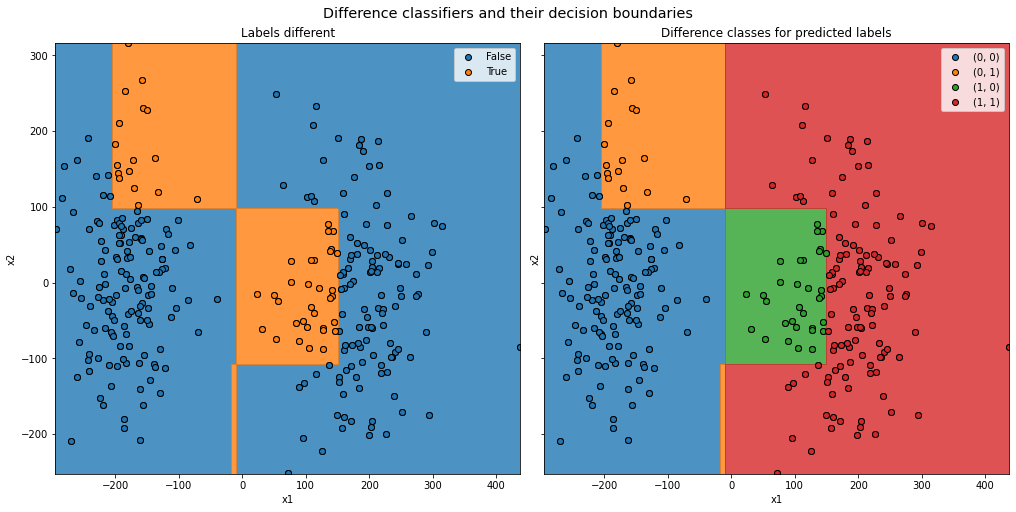

In [5]:
comparer.plot_decision_boundaries(X)

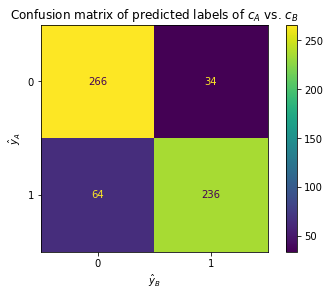

In [6]:
comparer.plot_confusion_matrix(X)

In [10]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.48 s, sys: 190 ms, total: 6.67 s
Wall time: 6.93 s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [11]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((600, 2), (0,), (0,))

In [16]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
X = pd.DataFrame(explanations.data, columns=explanations.feature_names)

# Global Explanations

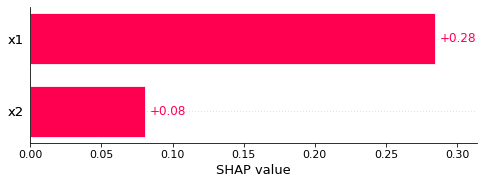

In [14]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
global_feature_order = feature_order
plot_feature_importance_bar(feature_importances)

In [17]:
X.iloc[:, feature_order].describe()

,x1,x2
count,600.000000,600.000000
mean,-2.920353,-3.233006
std,187.847698,101.166569
min,-293.394649,-251.957930
25%,-183.444208,-74.866120
50%,-8.544833,-6.890370
75%,174.936232,60.078319
max,437.353481,316.096597


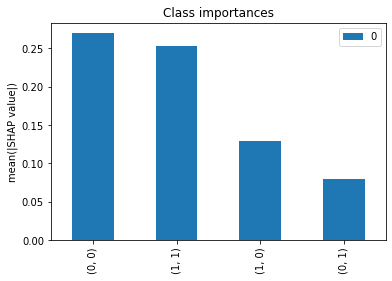

In [19]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [20]:
class_order = np.arange(class_order.shape[0])

In [21]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx], class_order], color=is_pred_diff)
it = iter(feature_order)

- $(0,1)$: peak influence in certain range between approx. -200 and 0
- $(1,0)$: peak influence in certain range between approx. 0 and 200

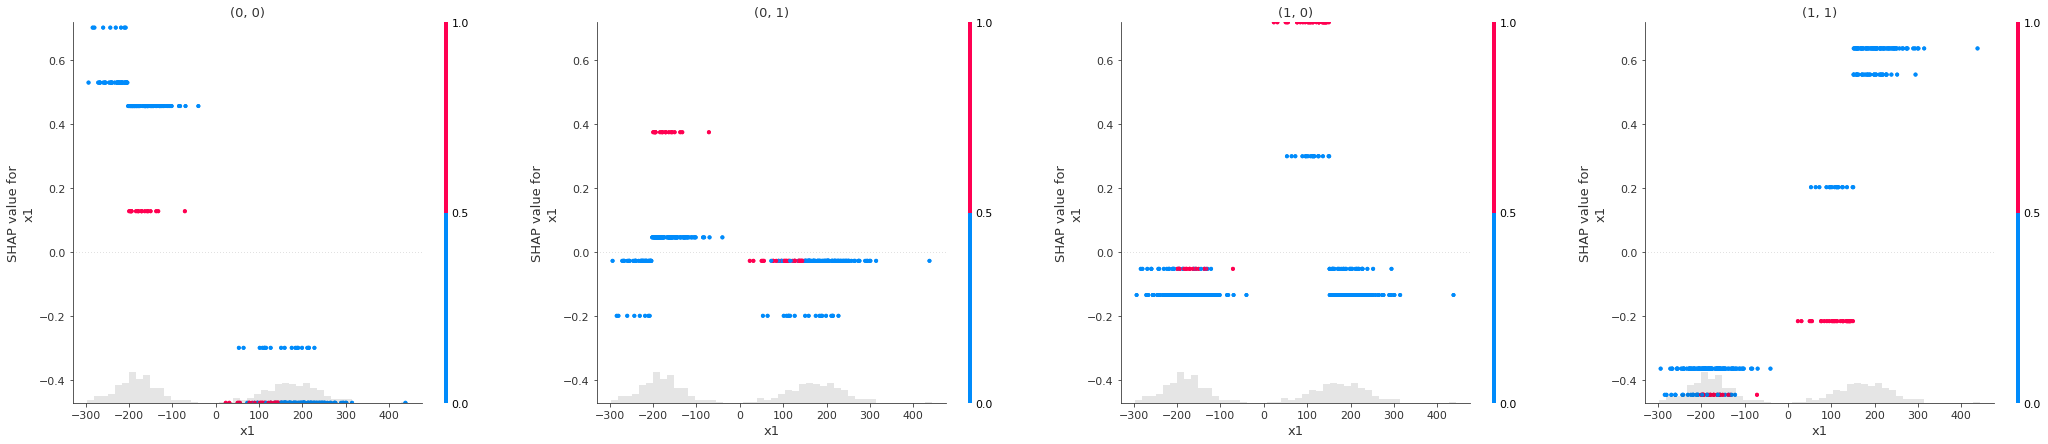

In [22]:
plot_next_feature()

- $(0,1)$: peak influence from approx. 100 upwards
- $(1,0)$: peak influence in certain range between approx. -100 and 100

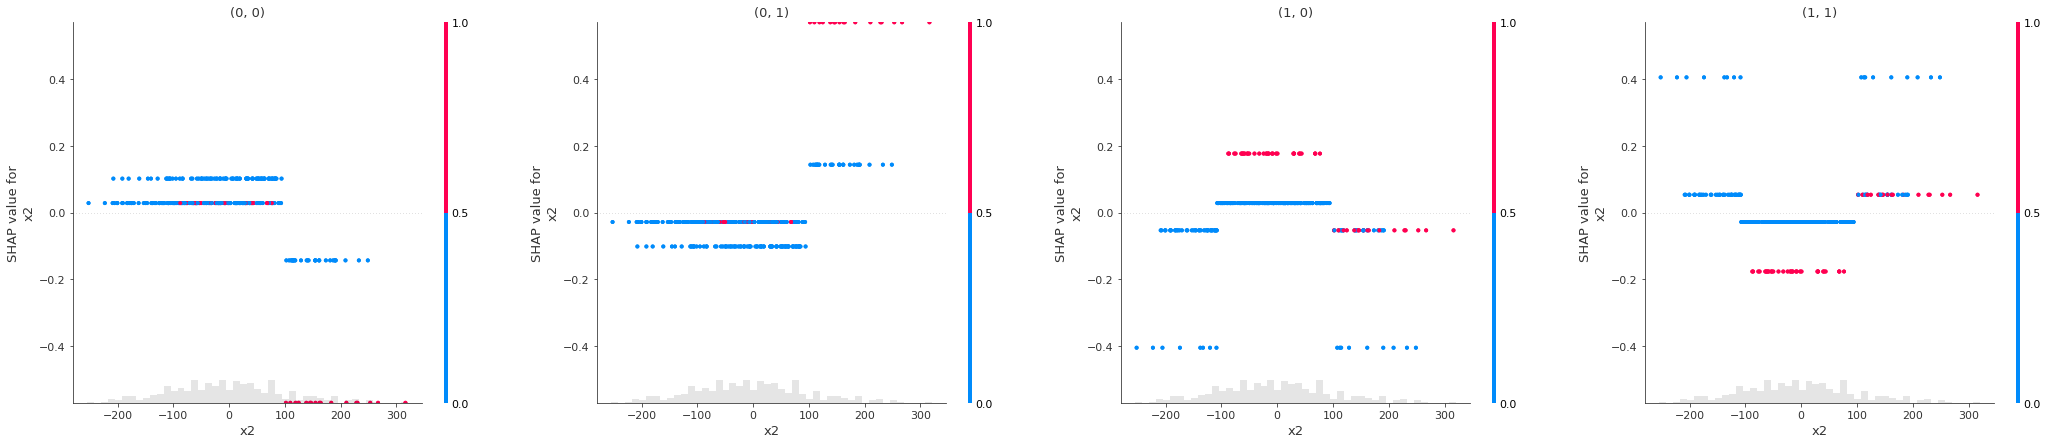

In [23]:
plot_next_feature()

# Local Explanations

In [24]:
pred_classes = comparer.class_names[mclass_diff]

In [32]:
def get_cluster(cluster):
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names

## Clustering of Class $(0,1)$ SHAP Values

In [115]:
diff_class = '(0, 1)'
shap_values = explanations.mclass_diff.labels[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

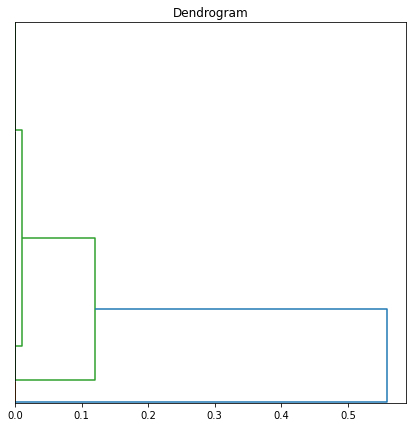

In [116]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [117]:
n_clusters = 2
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.labels.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,34,0,0
c2,266,0,64,236


In [118]:
cluster, shap_values, pred_classes = get_cluster('c1')
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,34,0,0


Instances in this cluster are characterized by:
- x1 ranges from -200 to -71
- x2 ranges from 101 upwards

That means:
- x1 has a high increasing effect on the outcome of class $(0,1)$ which decreases rapidly below and above this range; below the effect of $(0,0)$ increases, above the effect of $(1,0)$ and $(1,1)$ increases.
- x2 has a high increasing effect on the outcome of class $(0,1)$ which decreases rapidly below this range; below the effect of $(0,0)$ and $(1,0)$ increases.

In [119]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,x1,x2
count,34.000000,34.000000
mean,-166.755088,179.696581
std,31.750327,60.427552
min,-199.699165,101.871705
25%,-194.312742,138.378103
50%,-171.292900,162.109298
75%,-155.854926,228.253964
max,-71.253414,316.096597


In [120]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x1'] = -204
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,34.0
"(0, 1)",34.0,NaN


In [121]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x1'] = -8
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",34.0,NaN
"(1, 1)",NaN,34.0


In [122]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x2'] = 97
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,34.0
"(0, 1)",34.0,NaN


## Clustering of Class $(1,0)$ SHAP Values

In [74]:
diff_class = '(1, 0)'
shap_values = explanations.mclass_diff.labels[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

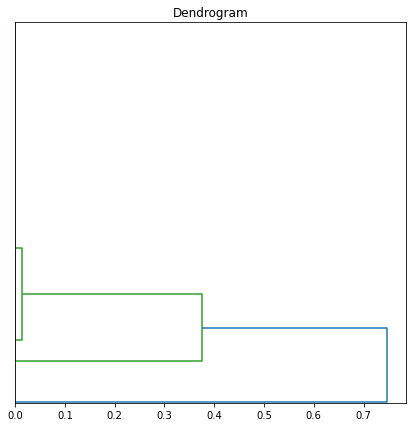

In [75]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [76]:
n_clusters = 2
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.labels.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,64,0
c2,266,34,0,236


In [77]:
cluster, shap_values, pred_classes = get_cluster('c1')
classes = ['(0, 0)', '(1, 0)', '(1, 1)']

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,64,0


Instances in this cluster are characterized by:
- x1 ranges from 23 to 150
- x2 ranges from -87 to 77

That means:
- x1 has a high increasing effect on the outcome of class $(1,0)$ which decreases rapidly below and above this range; below the effect of $(0,0)$ and $(0,1)$ increases, above the effect of $(1,1)$ increases.
- x2 has a high increasing effect on the outcome of class $(1,0)$ which decreases rapidly below and above this range; both below and above the effect of $(1,1)$ increases.

In [78]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,x1,x2
count,64.000000,64.000000
mean,107.604129,-17.055967
std,35.069628,47.776126
min,23.067264,-87.589637
25%,88.511143,-58.541738
50%,113.224582,-18.991429
75%,137.889674,29.322817
max,149.935488,76.762508


In [87]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x1'] = -9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,64.0
"(1, 0)",64.0,NaN


In [92]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x1'] = 151
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0


In [101]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x2'] = -109
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0


In [108]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['x2'] = 98
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0
